In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from keras.datasets import mnist
import cv2

In [3]:
model_weights_file_output_path = "./digit_classifier_model.ckpt"
(x_train, y_train), (x_test, y_test) = mnist.load_data()

(60000, 28, 28)
(60000,)


Convolutional neural network with ReLu activation and Adam optimizer from:
"CNN Model for Image Classification on MNIST and Fashion-MNIST Dataset" by Kadam, Shivam S. et. al. published in Journal of Scientific Research Volume 64, Issue 2, 2020

In [11]:
# Function for creating model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),

        tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(rate=0.25),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(rate=0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10),
        tf.keras.layers.Softmax()
    ])

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00005),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    
    return model


Epoch 1/20
1688/1688 [==============================] - 29s 17ms/step - loss: 0.6297 - accuracy: 0.7969 - val_loss: 0.1234 - val_accuracy: 0.9645
Epoch 2/20
1688/1688 [==============================] - 29s 17ms/step - loss: 0.1963 - accuracy: 0.9399 - val_loss: 0.0794 - val_accuracy: 0.9785
Epoch 3/20
1688/1688 [==============================] - 29s 17ms/step - loss: 0.1367 - accuracy: 0.9581 - val_loss: 0.0641 - val_accuracy: 0.9837
Epoch 4/20
1688/1688 [==============================] - 28s 17ms/step - loss: 0.1088 - accuracy: 0.9664 - val_loss: 0.0544 - val_accuracy: 0.9850
Epoch 5/20
1688/1688 [==============================] - 29s 17ms/step - loss: 0.0902 - accuracy: 0.9716 - val_loss: 0.0488 - val_accuracy: 0.9867
Epoch 6/20
1688/1688 [==============================] - 31s 18ms/step - loss: 0.0796 - accuracy: 0.9754 - val_loss: 0.0422 - val_accuracy: 0.9885
Epoch 7/20
1688/1688 [==============================] - 30s 18ms/step - loss: 0.0671 - accuracy: 0.9786 - val_loss: 0.0393 -

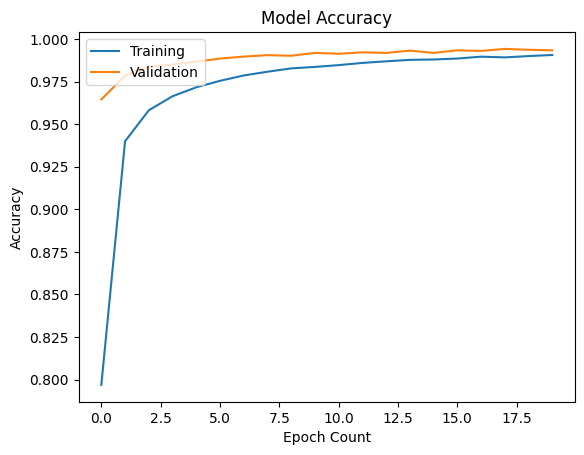

INFO:tensorflow:Assets written to: ./digit_classifier_model.ckpt/assets


INFO:tensorflow:Assets written to: ./digit_classifier_model.ckpt/assets


In [12]:
# Train and save model
model = create_model()

# Train model
training_history = model.fit(np.stack(x_train), y_train, validation_split=0.1, epochs=20)

# Plot training metrics
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Count')
plt.legend(['Training', "Validation"], loc='upper left')
plt.show()

# Save model
model.save(model_weights_file_output_path)

In [24]:
# Load model
model = create_model()
model.load_weights(model_weights_file_output_path)

2023-09-21 10:58:57.944585: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./digit_classifier_model.ckpt: FAILED_PRECONDITION: digit_classifier_model.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [22]:
def performance_metrics(model, x_data, y_data):
    predictions = [np.argmax(arr) for arr in model.predict(np.stack(x_data))]
    score = model.evaluate(x_data, y_data, verbose=0)
    loss = score[0]
    accuracy = score[1]

    num_positives = [0] * 10 # Number of times a number appears in y_data
    num_true_positives = [0] * 10 # Number of times we correctly predicted each class
    num_predictions = [0] * 10 # Number of times we predicted each class
    for i in range(len(y_data)):
        num_positives[y_data[i]] += 1
        num_predictions[predictions[i]] += 1
        if (y_data[i] == predictions[i]):
            num_true_positives[y_data[i]] += 1
    
    recall = [num_true_positives[i] / num_positives[i] for i in range(10)]
    precision = [num_true_positives[i] / num_predictions[i] for i in range(10)]
    f1_score = [(2 * recall[i] * precision[i]) / (recall[i] + precision[i]) for i in range(10)]

    NUM_ROUND_DIGITS = 5

    return {"loss" : round(loss, NUM_ROUND_DIGITS), 
            "accuracy" : round(accuracy, NUM_ROUND_DIGITS), 
            "precision" : [round(x, NUM_ROUND_DIGITS) for x in precision], 
            "recall" : [round(x, NUM_ROUND_DIGITS) for x in recall], 
            "f1" : [round(x, NUM_ROUND_DIGITS) for x in f1_score]}

# Display the predictions on x_data and x_data images in N_ROWS by N_COLS grids
def display_predictions(model, x_data, N_ROWS, N_COLS):
    # Predictions on data set
    predictions = [np.argmax(arr) for arr in model.predict(np.stack(x_data))]

    # Create subplot for display
    fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(3,3))
    np.vectorize(lambda axis : axis.axis("off"))(ax) # Turn of axis labels

    images = [Image.fromarray(arr) for arr in x_data]

    # Display images of data set
    img_count = 0
    for i in range(N_ROWS):
        for j in range(N_COLS):        
            if img_count < len(images):
                ax[i, j].imshow(images[img_count])
                img_count+=1

    # Display predictions on data set
    value_count = 0
    for i in range(N_ROWS):
        for j in range(N_COLS):
            if value_count < len(predictions):
                print(predictions[value_count], end=' ')
                value_count += 1
        print('')

1875/1875 [==============================] - 10s 5ms/step
loss 0.01261
accuracy 0.99632
precision [0.99848, 0.99586, 0.99698, 0.9969, 0.99708, 0.99648, 0.99428, 0.99475, 0.99726, 0.99528]
recall [0.99865, 0.99837, 0.99765, 0.99641, 0.99504, 0.99317, 0.99865, 0.99713, 0.99539, 0.9921]
f1 [0.99857, 0.99711, 0.99732, 0.99666, 0.99606, 0.99483, 0.99646, 0.99593, 0.99632, 0.99369]
1875/1875 [==============================] - 10s 5ms/step
8 6 5 3 8 1 5 9 2 9 
8 7 0 6 2 1 2 6 6 3 
1 3 7 6 4 2 9 0 2 2 
9 5 8 6 1 3 7 8 3 5 
6 1 3 5 3 1 7 0 4 8 
8 9 5 8 5 0 4 9 4 0 
9 7 7 8 7 0 4 1 4 3 
0 6 9 8 7 6 5 4 3 2 
1 0 9 8 7 3 2 1 0 9 
8 7 6 5 4 3 2 1 0 4 


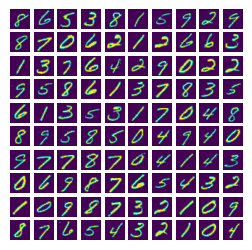

In [23]:
# Display predictions on validation set (always taken from end of data)
validation_metrics = performance_metrics(model, x_train[::-1], y_train[::-1])
for k, v in validation_metrics.items():
    print(k, v)
display_predictions(model, x_train[::-1], 10, 10)

In [25]:
# Predicts digit in image from a WHITE background
def predict_image(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((28, 28))

    # Convert so white 255 becomes black 0
    arr = np.array(img)
    for i in range(28):
        for j in range(28):
            arr[i, j] = 255 - arr[i, j]
            
    return np.argmax(model.predict(np.stack([arr])))

def display_image(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((28, 28))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
    np.vectorize(lambda axis : axis.axis("off"))(ax) # Turn of axis labels
    ax.imshow(img)

1/1 [==============================] - 0s 43ms/step
7


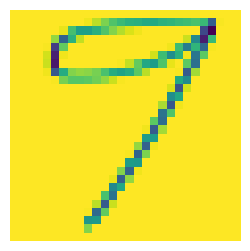

In [26]:
print(predict_image("./test_digits/9.png"))
display_image("./test_digits/9.png")

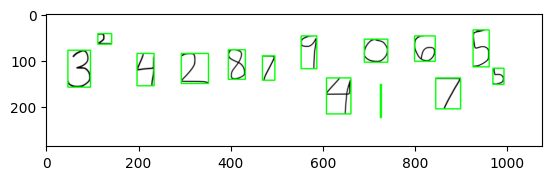

1/1 [==============================] - 0s 11ms/step


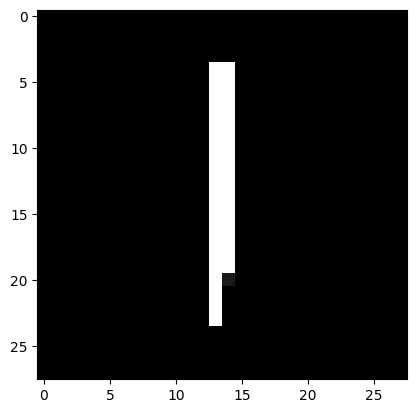

Predicted digit: 1
Probabilities from neural net: [[3.5295378e-07 9.9993515e-01 3.1794343e-07 7.4389828e-09 4.3807042e-05
  3.5375209e-07 3.9894085e-06 2.9005773e-06 1.1457661e-05 1.7076643e-06]]
1/1 [==============================] - 0s 9ms/step


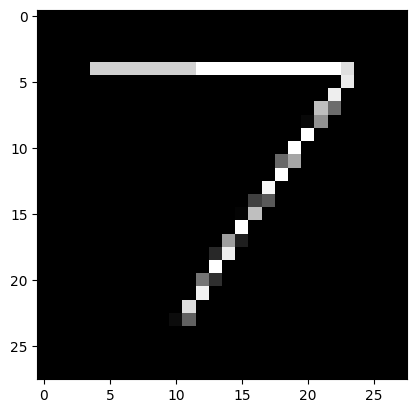

Predicted digit: 7
Probabilities from neural net: [[1.11389242e-03 7.20287394e-03 1.77163854e-01 2.37876084e-02
  3.23911139e-04 7.48282822e-04 1.17001124e-04 7.75767863e-01
  7.37071410e-03 6.40412653e-03]]
1/1 [==============================] - 0s 9ms/step


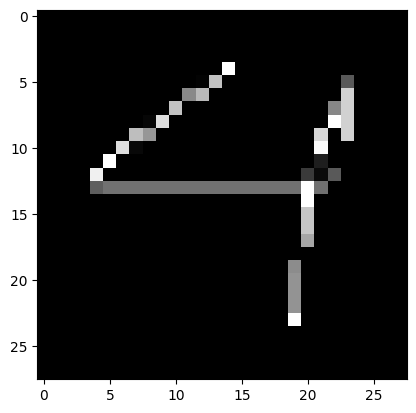

Predicted digit: 5
Probabilities from neural net: [[0.00323861 0.01182547 0.00926844 0.0226545  0.13592246 0.3026224
  0.00329106 0.28805146 0.06237626 0.16074939]]
1/1 [==============================] - 0s 9ms/step


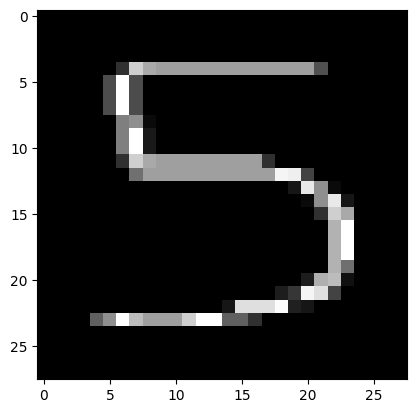

Predicted digit: 5
Probabilities from neural net: [[5.3354429e-06 2.8952045e-05 1.4870142e-07 3.4197283e-04 3.8197154e-06
  9.9809200e-01 6.5621125e-06 1.3857047e-03 4.1368476e-05 9.4185598e-05]]
1/1 [==============================] - 0s 12ms/step


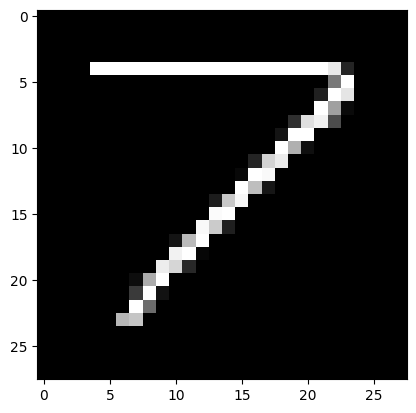

Predicted digit: 7
Probabilities from neural net: [[7.8410048e-06 6.1851658e-02 6.8836257e-02 1.3395459e-03 1.9827899e-05
  6.6219586e-06 3.2529597e-06 8.6421221e-01 3.2767698e-03 4.4600375e-04]]
1/1 [==============================] - 0s 13ms/step


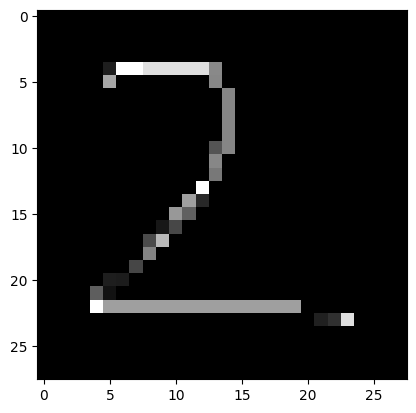

Predicted digit: 2
Probabilities from neural net: [[6.4560649e-04 7.0028730e-02 9.0258920e-01 2.1633154e-02 1.8556895e-04
  1.8778324e-04 1.2715007e-04 7.9298456e-04 3.6454075e-03 1.6441861e-04]]
1/1 [==============================] - 0s 11ms/step


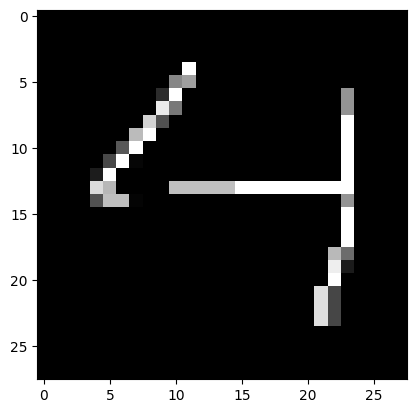

Predicted digit: 4
Probabilities from neural net: [[2.1730813e-04 8.0654380e-04 4.3368712e-03 2.2634461e-03 4.9276617e-01
  1.7176224e-01 1.1001005e-03 2.9805335e-01 2.2382583e-02 6.3113323e-03]]
1/1 [==============================] - 0s 10ms/step


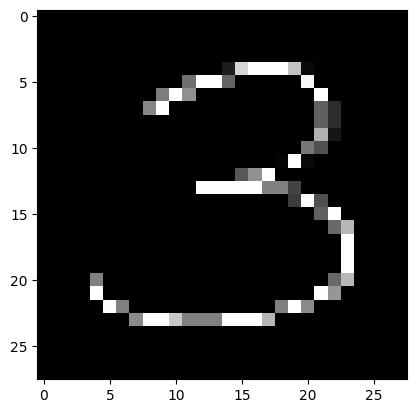

Predicted digit: 3
Probabilities from neural net: [[2.9719532e-08 8.6671798e-06 2.5351575e-05 9.9900061e-01 4.5289653e-08
  9.1392797e-04 2.1768514e-07 7.8292851e-06 2.8337692e-05 1.4904858e-05]]
1/1 [==============================] - 0s 11ms/step


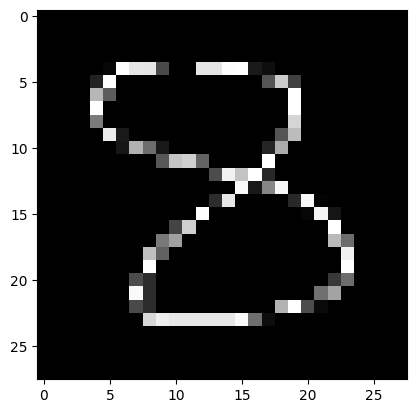

Predicted digit: 8
Probabilities from neural net: [[2.64763494e-05 1.79553055e-04 1.49417728e-01 2.81804614e-02
  2.17946617e-05 1.28909043e-04 3.92520960e-05 9.90565386e-05
  8.21804583e-01 1.02187085e-04]]
1/1 [==============================] - 0s 10ms/step


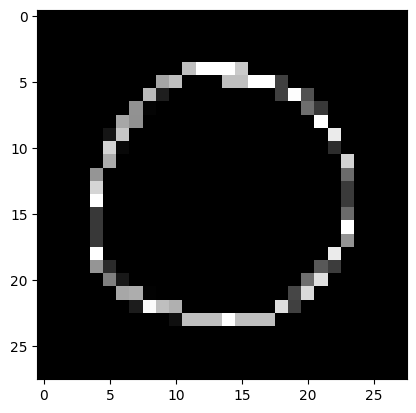

Predicted digit: 0
Probabilities from neural net: [[7.9543537e-01 5.4346654e-03 3.5268117e-02 1.0031250e-01 3.5290628e-05
  2.4484729e-02 6.1468146e-04 6.0830754e-04 2.1629813e-03 3.5643328e-02]]
1/1 [==============================] - 0s 10ms/step


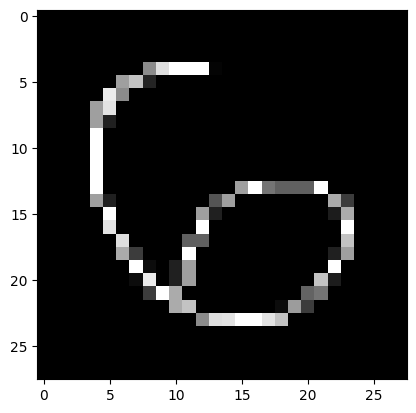

Predicted digit: 6
Probabilities from neural net: [[4.5060623e-03 7.3898106e-04 2.1892009e-02 2.6286116e-02 1.0593539e-04
  1.5416274e-02 8.5351044e-01 1.3819123e-04 7.7070877e-02 3.3500613e-04]]
1/1 [==============================] - 0s 9ms/step


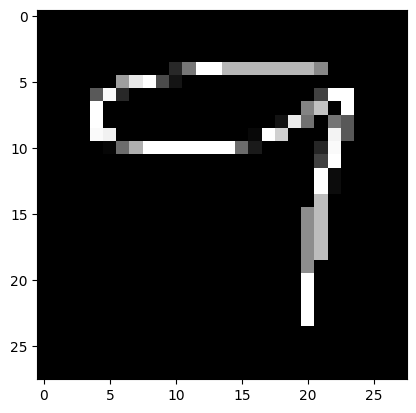

Predicted digit: 7
Probabilities from neural net: [[2.1755674e-05 3.3756827e-05 5.9361529e-04 3.1787559e-04 4.7701420e-04
  2.0464294e-04 2.8065332e-07 9.8836821e-01 4.7110242e-04 9.5117083e-03]]
1/1 [==============================] - 0s 9ms/step


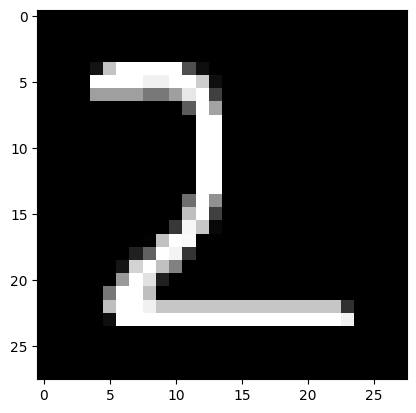

Predicted digit: 2
Probabilities from neural net: [[4.0197484e-08 1.4267546e-04 9.9983549e-01 1.2823650e-08 1.1983997e-09
  1.0708932e-10 6.5222383e-10 2.7376443e-09 2.1791508e-05 1.7464986e-11]]
1/1 [==============================] - 0s 10ms/step


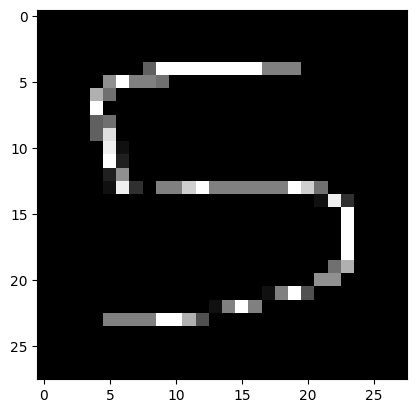

Predicted digit: 5
Probabilities from neural net: [[6.9239890e-05 2.1461446e-03 4.0219747e-04 1.0379004e-01 1.2464974e-04
  8.7394142e-01 2.8962098e-04 1.4570907e-02 1.6354240e-03 3.0303861e-03]]


In [24]:
# Predictions on images with multiple digits

image = cv2.imread('./test_digits/digits2.png')
grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

preprocessed_digits = []
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    
    # Creating bounding box
    cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)
    
    # Cropping out the digit from the image
    digit = thresh[y:y+h, x:x+w]
    
    # Resize image, but don't disproportionately scale it
    resized_width = min(20, int(1.25 * w))
    resized_height = min(20, int(1.25 * h))
    if resized_width % 2 == 1: resized_width += 1 # Must scale to even number so padding is same on both sides
    if resized_height % 2 == 1: resized_height += 1 # Must scale to even number so padding is same on both sides
    resized_digit = cv2.resize(digit, (resized_width, resized_height))
    

    remaining_pad_width = (28 - resized_width) // 2
    remaining_pad_height = (28 - resized_height) // 2
    padded_digit = np.pad(resized_digit, ((remaining_pad_height, remaining_pad_height),(remaining_pad_width, remaining_pad_width)), "constant", constant_values=0)

    preprocessed_digits.append(padded_digit)

plt.imshow(image, cmap="gray")
plt.show()
    

for digit in preprocessed_digits:
    prediction = model.predict(digit.reshape(1, 28, 28, 1))  
    
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.show()
    print("Predicted digit: {}".format(np.argmax(prediction)))
    print ("Probabilities from neural net: {}".format(prediction))